In [2]:
from matplotlib import pyplot as pl
from scipy import signal 
import scikits.audiolab as audiolab
import matplotlib.pyplot as pl
import os
import numpy as np
import csv
import VectorQuantizer as vq
import HartiganOnline as hartigan
import spectrogram


%matplotlib inline

data_dir = '/home/mzhan/audiosearch/data/UrbanSound8K/audio' 
metadata_path = '/home/mzhan/audiosearch/data/UrbanSound8K/metadata/UrbanSound8K_by_fold.csv'
feature_path = '/home/mzhan/audiosearch/data/UrbanSound8K/features2.npy'


/usr/local/lib/python2.7/dist-packages/scikits.audiolab-0.11.0-py2.7-linux-x86_64.egg/scikits/audiolab/soundio/play.py:48: UserWarning: Could not import alsa backend; most probably, you did not have alsa headers when building audiolab
  warnings.warn("Could not import alsa backend; most probably, "


# 1. Data Overview

In [399]:
import random
import pyaudio  
import wave  

def random_audio_file():
    fold = random.choice(os.listdir(data_dir))
    if fold[:4]!='fold':
        return random_audio_file()
    fname = random.choice(os.listdir(os.path.join(data_dir, fold)))
    return os.path.join(data_dir, fold, fname)

def play_wave(fname):
    try:  # Use the wave package to read
        #define stream chunk   
        chunk = 1024  

        #open a wav format music  
        f = wave.open(fname,"rb")  
        #instantiate PyAudio  
        p = pyaudio.PyAudio()  
        #open stream  
        stream = p.open(format = p.get_format_from_width(f.getsampwidth()),  
                        channels = f.getnchannels(),  
                        rate = f.getframerate(),  
                        output = True)  
        #read data  
        data = f.readframes(chunk)  

        #paly stream  
        while data != '':  
            stream.write(data)  
            data = f.readframes(chunk)  

        #stop stream  
        stream.stop_stream()  
        stream.close()  

        #close PyAudio  
        p.terminate()  
    except Exception as e:
        print 'Cannot open', fname
    
def show_wav(w, sr=44100):
    print len(w), sr
    if len(w.shape)>1:
        w = w[:,0]    # take only 1 channel if stereo
    pl.figure()
    pl.plot(w)
    pl.ylim([-1,1])
    frameSize = sr*0.02
    S = spectrogram.stft(w, frameSize)
    print S.shape
    pl.figure()
    pl.imshow(np.log(abs(S).T), origin="lower", aspect="auto", interpolation="none")

### View (hear) random audio file

pcm24
(61019, 2)
96000
61019 96000
(64, 961)


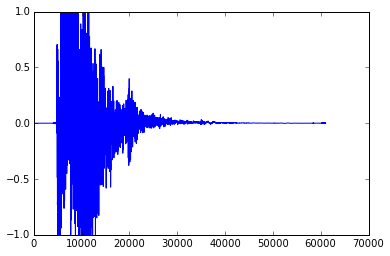

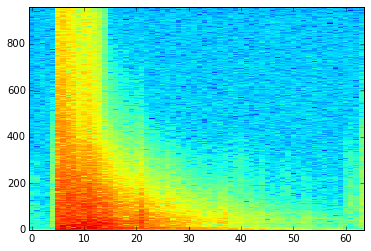

In [269]:
f = random_audio_file()

s = audiolab.Sndfile(f)
#show_wav(w/(2.0**31),sr)
print s.encoding
w = s.read_frames(s.nframes)
print w.shape
print s.samplerate
show_wav(w, s.samplerate)
#play_wave(f)

61019 96000
(64, 961)
28030 44100
(64, 442)
Cannot open /home/mzhan/audiosearch/data/UrbanSound8K/audio/fold3/162431-6-2-0.wav


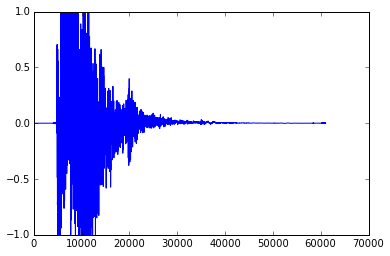

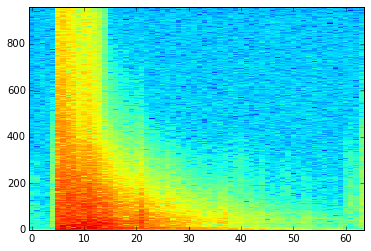

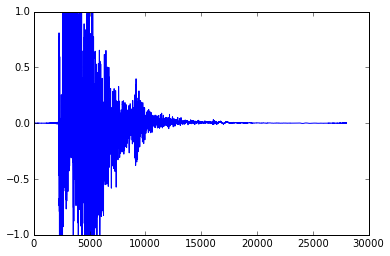

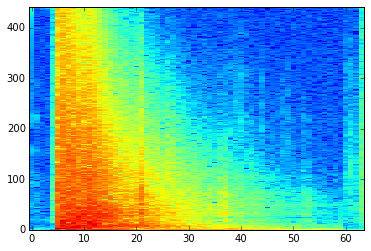

In [272]:
import scipy.signal as sig
sr = 44100
resampled = sig.resample(w, 1.*s.nframes/s.samplerate*sr)
show_wav(w, s.samplerate)
show_wav(resampled, sr)
play_wave(f)

### data generator

In [274]:
errorfiles = []
def data_gen(verbose=False, start=None):
    """ 
    Generate spectrogram for each audio file (in log amplitude). 
    Yields numpy array of shape (n,d) where n is number of windows (number of frames in file) and 
    d is STFT resolution (frame dimension).
    """
    SR = 44100   # standard sampling rate
    with open(metadata_path, 'rb') as fmeta:
        meta = csv.reader(fmeta, delimiter=',')
        meta.next()   # skip header
        if start:
            # skip <start> rows
            [meta.next() for i in range(start)]
        for line in meta:
            fname, fsID, start, end, salience, fold, classID, className = line
            if verbose:
                print fname, fold
            try: 
                s = audiolab.Sndfile(os.path.join(data_dir, 'fold'+str(fold), fname))
                w = s.read_frames(s.nframes)    # bitdepth: float in range [-1,1]
                if len(w.shape)>1:
                    w = w[:,0]    # take the first channel when multiple are present
                # unify sample rates
                if s.samplerate==SR:
                    resampled = w
                else:
                    resampled = signal.resample(w, 1.*s.nframes/s.samplerate*SR)   
                frameSize = SR*0.02   # frame duration = 20ms
                S = spectrogram.stft(resampled, frameSize)
                yield np.log(np.abs(S))
            except:
                errorfiles.append((fold, fname))   # ignore files that can't be opened by wave package


In [3]:
errorfiles = []
def snd_gen(start=None):
    """ 
    Generate audio files as audiolab.Sndfile classes
    """
    with open(metadata_path, 'rb') as fmeta:
        meta = csv.reader(fmeta, delimiter=',')
        meta.next()   # skip header
        if start:
            # skip <start> rows
            [meta.next() for i in range(start)]
        for line in meta:
            fname, fsID, start, end, salience, fold, classID, className = line
            try: 
                s = audiolab.Sndfile(os.path.join(data_dir, 'fold'+str(fold), fname))
                yield s
            except:
                errorfiles.append((fold, fname))   # ignore files that can't be opened by wave package
                
def snd2spec(s):
    """ s: Sndfile object
    return: log-amplitude spectrogram in shape (n,d)
    """
    SR = 44100   # standard sampling rate
    w = s.read_frames(s.nframes)
    # unify sample rates
    if s.samplerate==SR:
        resampled = w
    else:
        resampled = signal.resample(w, 1.*s.nframes/s.samplerate*SR)   
    frameSize = SR*0.02   # frame duration = 20ms
    if len(w.shape)>1:
        w = w[:,0]    # take the first channel when multiple are present   
    S = spectrogram.stft(resampled, frameSize)
    return np.log(np.abs(S))

In [408]:
print "original sample rates:", list(set(samplerates))
[sum(np.array(samplerates)==sr) for sr in set(samplerates)]

original sample rates: [48000, 96000, 22050, 44100, 8000, 32000, 11024, 11025, 24000, 192000, 16000]


[2502, 610, 44, 5370, 12, 4, 7, 39, 82, 17, 45]

### Clustering audio frames (kmeans)

In [7]:
NC = 512

In [17]:
quantizer = vq.VectorQuantizer(clusterer=hartigan.HartiganOnline(n_clusters=NC))
max_iter = 5
centroids = np.zeros((max_iter, 8, NC, 442))

In [309]:
i=0
print "iteration", i+1
#g = data_gen()   # reset generator
#fcount=0
for d in g:
    #print d.shape
    quantizer.partial_fit(d)    
    fcount+=1
    if not fcount%50:
        print fcount, 'files processed'
    if fcount>0 and not fcount%1000:
        # save centroids
        centroids[i, fcount/1000-1] = quantizer.components_


iteration 1
5250 files processed
5300 files processed
5350 files processed
5400 files processed
5450 files processed
5500 files processed
5550 files processed
5600 files processed
5650 files processed
5700 files processed
5750 files processed
5800 files processed
5850 files processed
5900 files processed
5950 files processed
6000 files processed
6050 files processed
6100 files processed
6150 files processed
6200 files processed
6250 files processed
6300 files processed
6350 files processed
6400 files processed
6450 files processed
6500 files processed
6550 files processed
6600 files processed
6650 files processed
6700 files processed
6750 files processed
6800 files processed
6850 files processed
6900 files processed
6950 files processed
7000 files processed
7050 files processed
7100 files processed
7150 files processed
7200 files processed
7250 files processed
7300 files processed
7350 files processed
7400 files processed
7450 files processed
7500 files processed
7550 files processed
7

In [411]:
fcount

8727

In [321]:
np.save('centroids151209', centroids)

In [20]:
reload(vq)
centroids = np.load('/home/mzhan/audiosearch/centroids151209.npy')
centroids[0,0].shape
quantizer.load_centroids(centroids[0,7])

#### Visualize clustering results

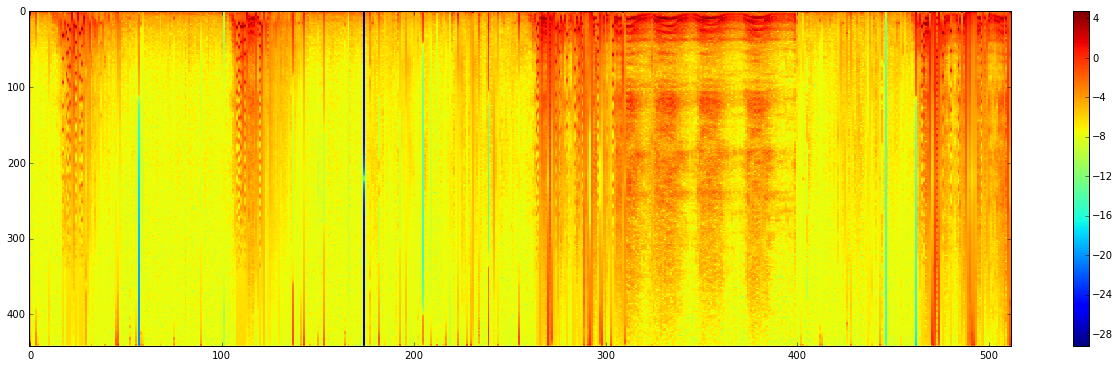

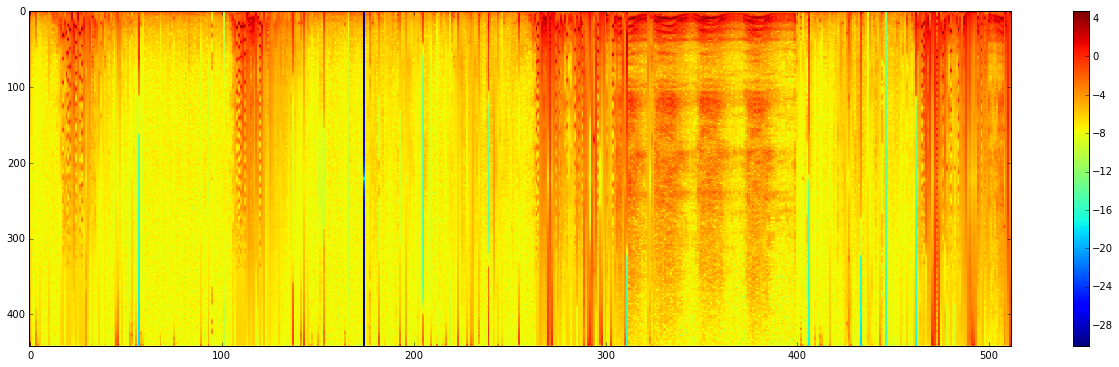

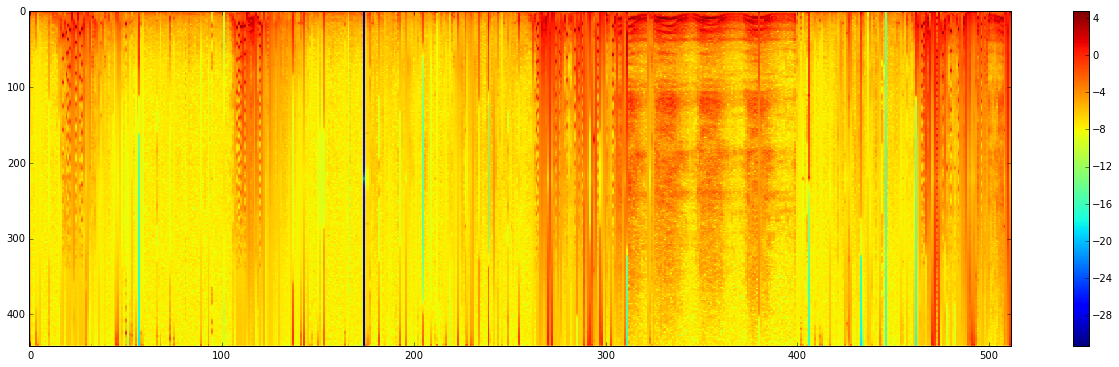

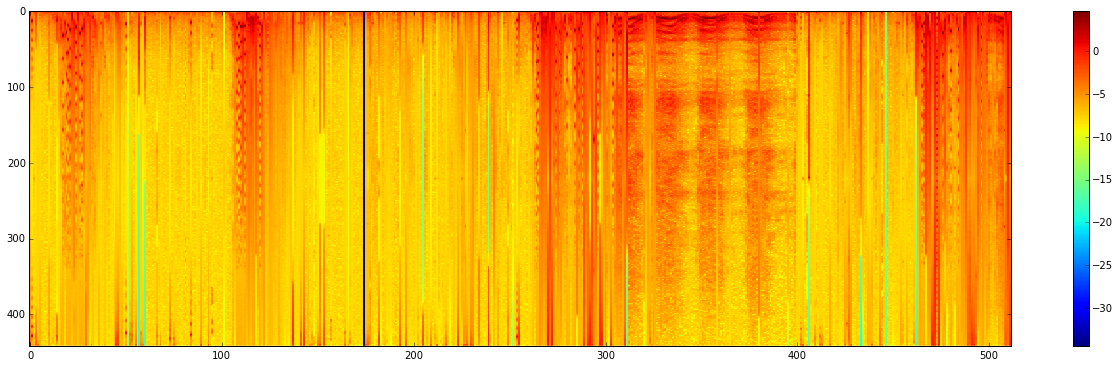

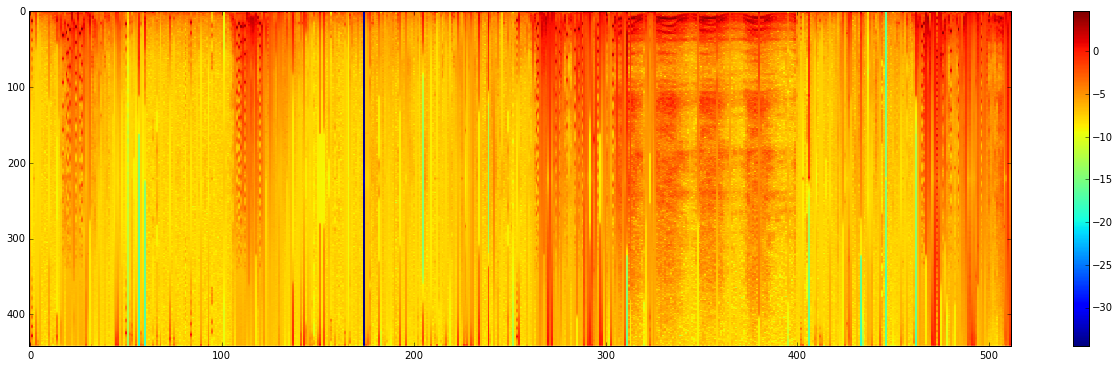

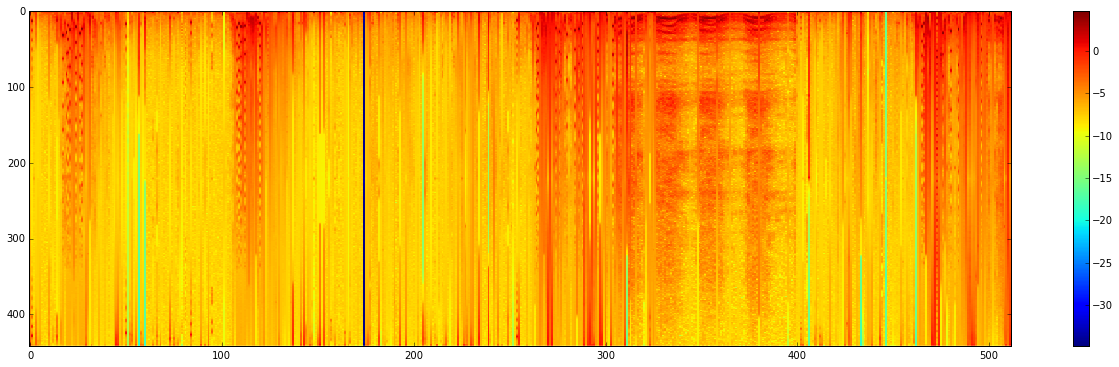

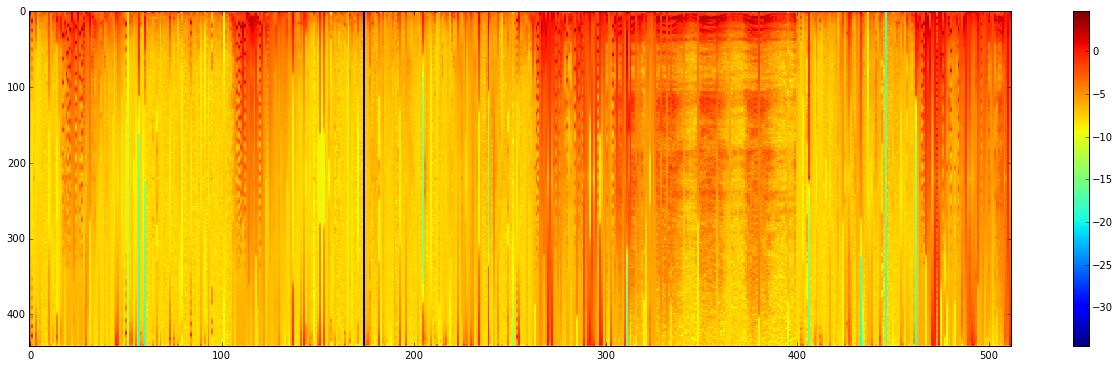

In [312]:
def show_codewords(codewords):
    pl.figure(figsize=(22,6))
    pl.imshow(codewords.T, aspect="auto", interpolation="none")
    pl.colorbar()
    
    
for i in range(fcount/1000-1):
    show_codewords(centroids[0,i])

## Feature Exaction

Each audio file is transformed into a histogram of cluster assignments. Here's a random file:

In [21]:
def extract_feature(s, quantizer):
    S = snd2spec(s)
    quantized = quantizer.transform(S)
    bins =  quantized.sum(0)
    #print bins
    return bins

In [4]:
d = random_audio_file()
print d
s = audiolab.Sndfile(d)
pl.plot(extract_feature(s).A.flatten())
#print quantized

NameError: name 'random_audio_file' is not defined

Now transform the whole dataset:

In [23]:
X = np.zeros((8732,NC))
fcount = 0
g = snd_gen()
#g = snd_gen(start=fcount-1)
print NC

for s in g:
    X[fcount] =  extract_feature(s, quantizer)
    fcount+=1
    if not fcount%50:
        print fcount
    if not fcount%500:
        np.save(feature_path, X)
    

Exception RuntimeError: 'generator ignored GeneratorExit' in <generator object snd_gen at 0x7f9d092c1e60> ignored
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


512
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:35: RuntimeWarning: divide by zero encountered in log


In [28]:
X=X[:-1]
np.save(feature_path, X)

In [497]:
sum(X.sum(1)==0)

0

8732


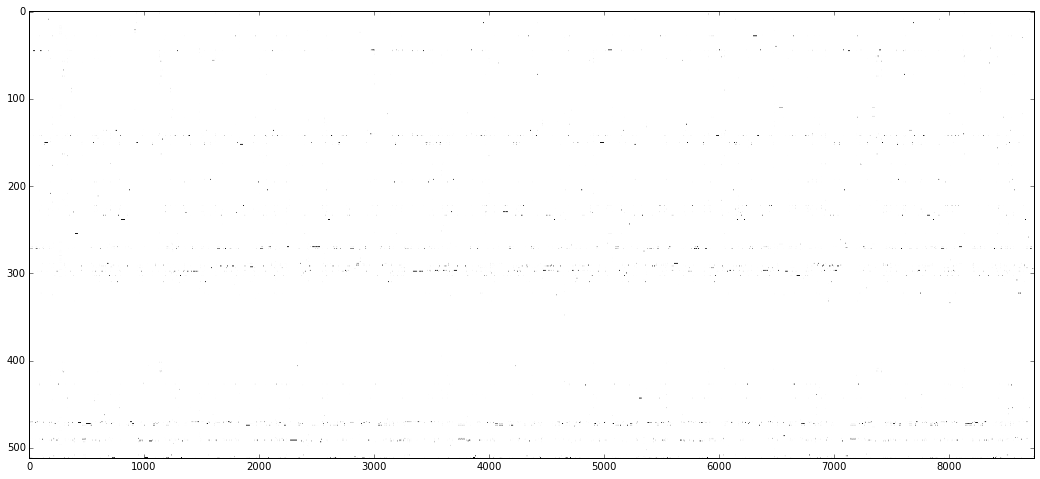

In [483]:
print fcount
pl.figure(figsize=(18,8))
pl.imshow(X[:fcount].T, aspect='auto', cmap = pl.get_cmap('Greys'))
np.save(feature_path, X)

In [450]:
empty = np.zeros((0,NC))
np.vstack((empty, empty)).shape


(0, 512)